<center>
    <h1>Fruit Inspection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

The first task considers the images in the folder `images/first task/`, that present apples with external defects which are clearly visible.

| NIR example                   | Colour example                |
|:-----------------------------:|:-----------------------------:|
| ![](attachment:C0_000001.png) | ![](attachment:C1_000001.png) |

In order to localize these defects two steps have to be carried out:
- Each fruit should be outlined by means of a binary mask that separates the foreground (the fruit) from the background. This step is performed through a tresholding technique;
- A search to identify the defects on the fruit must be carried out on the outlined portion of the image.

*Note: given the fact that NIR and color images have little parallax, a mask can be computed on one and applied to the other.*

#### Procedure
Although this is an academic project, the working pipeline has been developed considering an industrial setting where the inspection of the fruits has to be carried out by an *online* system. A set of methods have been tested in terms of quality, speed and robustness.

# 00 Prerequisites
The libraries necessary for the task are imported.

In [4]:
%matplotlib inline

import cv2 as cv
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
from time import time

# Utils libraries
from utils import *

The cell below illustrates the version of `OpenCV` used for the task.

In [7]:
print(f'Using OpenCV version: {cv.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [8]:
SEED = 42

cv.setRNGSeed(SEED)
np.random.seed(SEED)

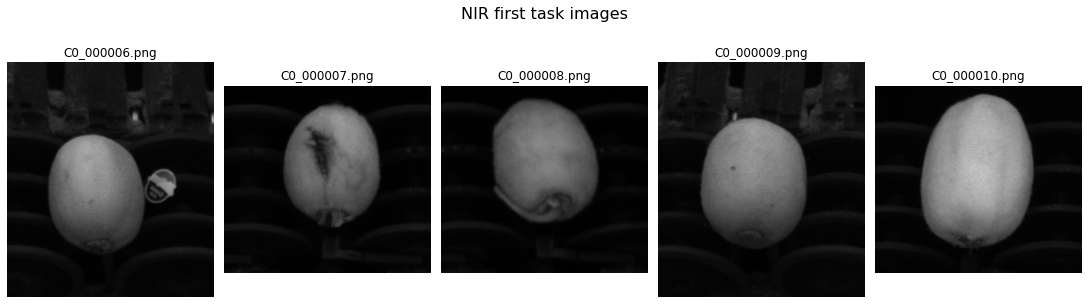

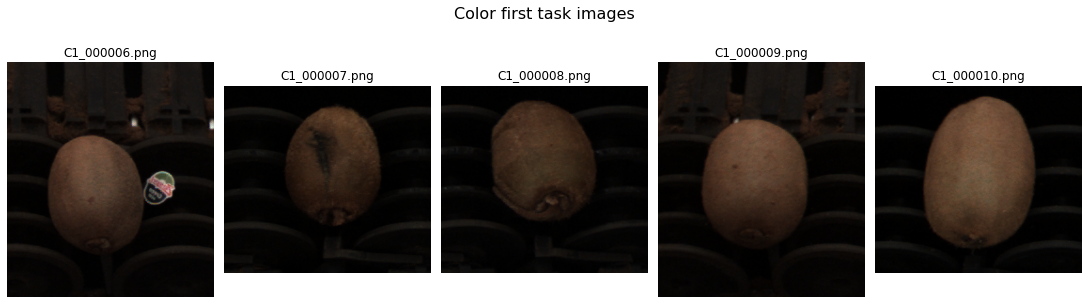

In [11]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, colour_names = [[f'C{j}_{str(i).zfill(6)}.png' for i in range(6,11)] for j in [0,1]]

# Directory where the images are saved
DIR = 'images/final challenge/'

# Import NIR and color images
nir_imgs = [cv.imread(f'{DIR}{img}', cv.IMREAD_GRAYSCALE) for img in nir_names]
colour_imgs = [cv.imread(f'{DIR}{img}') for img in colour_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, nir_names, 'NIR final challenge images')
plot_image_grid(colour_imgs, colour_names, 'Color final challenge images')

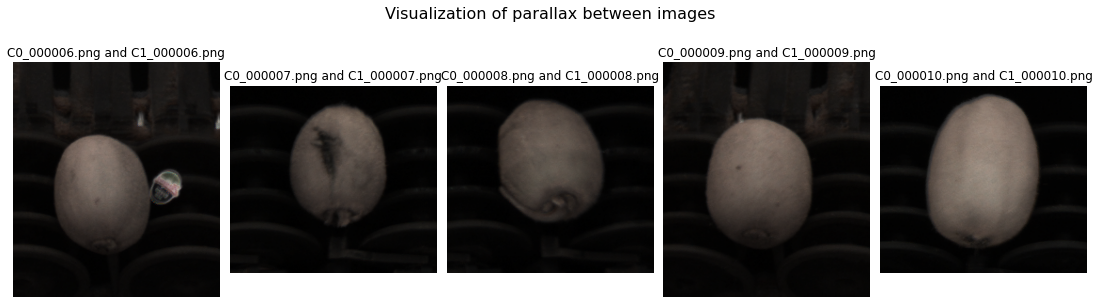

In [13]:
parallaxes = [cv.addWeighted(cv.cvtColor(n, cv.COLOR_GRAY2BGR), 0.5, c, 0.5, 0) 
              for n, c in zip(nir_imgs, colour_imgs)]

plot_image_grid(parallaxes, [f'{n} and {c}' for n, c in zip(nir_names, colour_names)], 
                'Visualization of parallax between images')

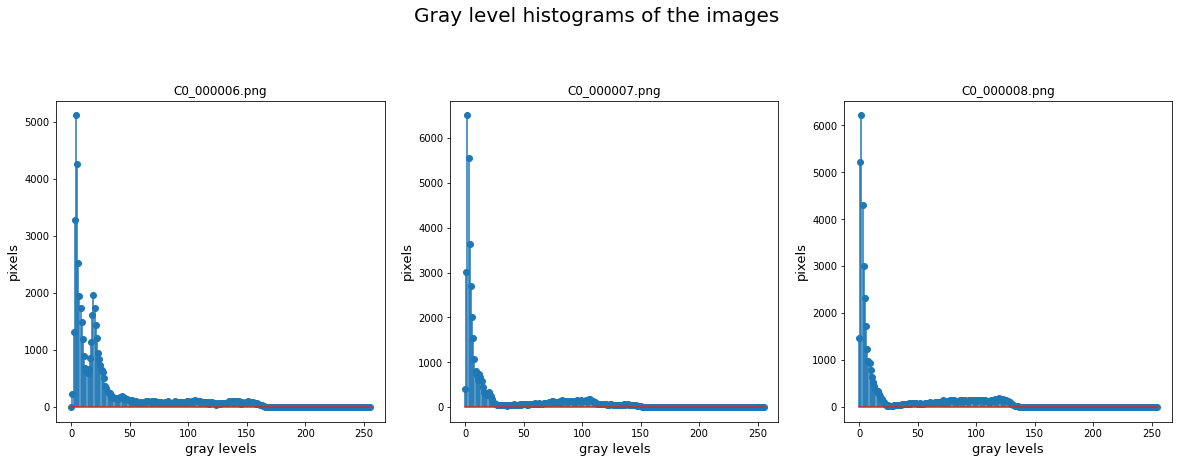

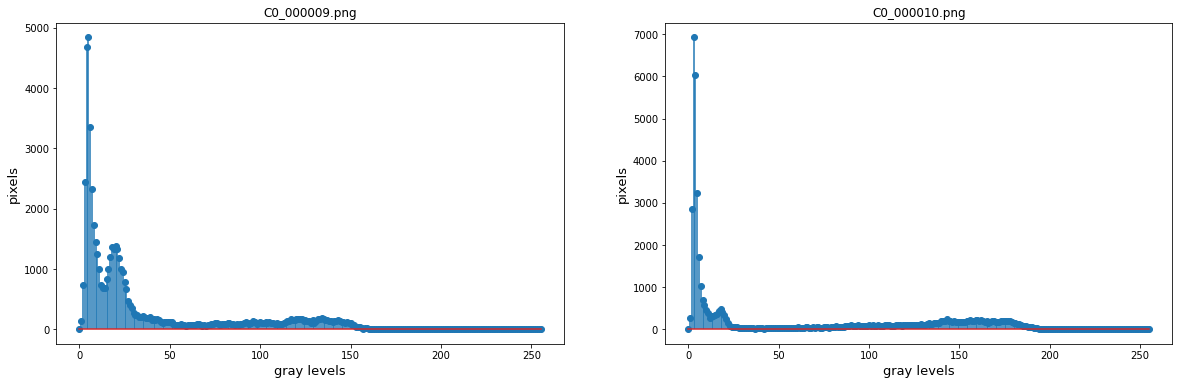

In [17]:
plot_histogram_grid(nir_imgs[:3], nir_names[:3], 'Gray level histograms of the images')
plot_histogram_grid(nir_imgs[3:], nir_names[3:], '')

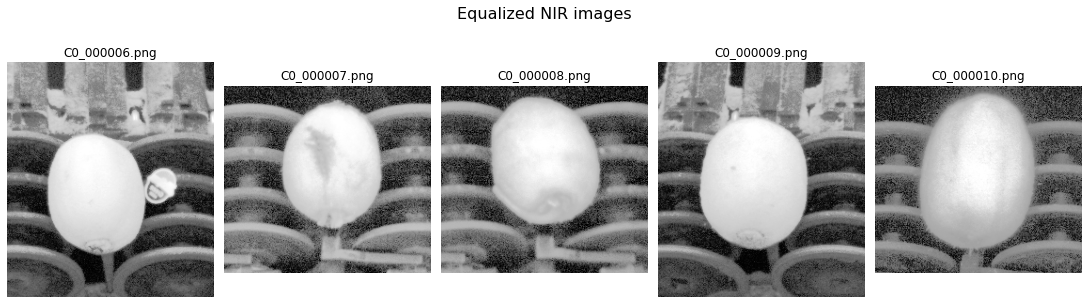

In [18]:
equalized_nir_imgs = [cv.equalizeHist(img) for img in nir_imgs]
plot_image_grid(equalized_nir_imgs, nir_names, 'Equalized NIR images')

Images are equalized because compared to the grayscale images of previous tasks, the range of poorly used histogram intensities is larger ($[150, 255]$)

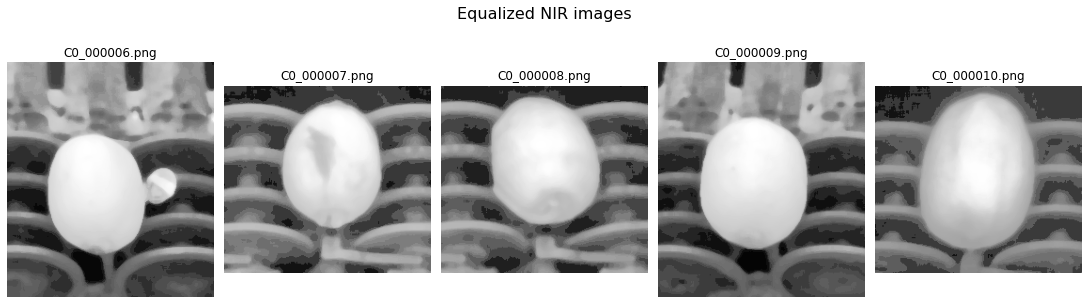

In [22]:
filtered_images = [cv2.medianBlur(img,7) for img in equalized_nir_imgs]
plot_image_grid(filtered_images, nir_names, 'Equalized NIR images')

In [58]:
filtered_images = [cv2.medianBlur(img,7) for img in nir_imgs]

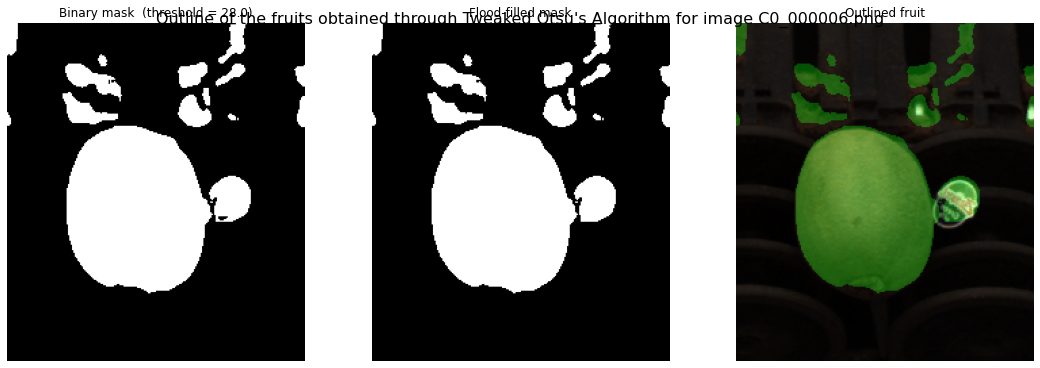

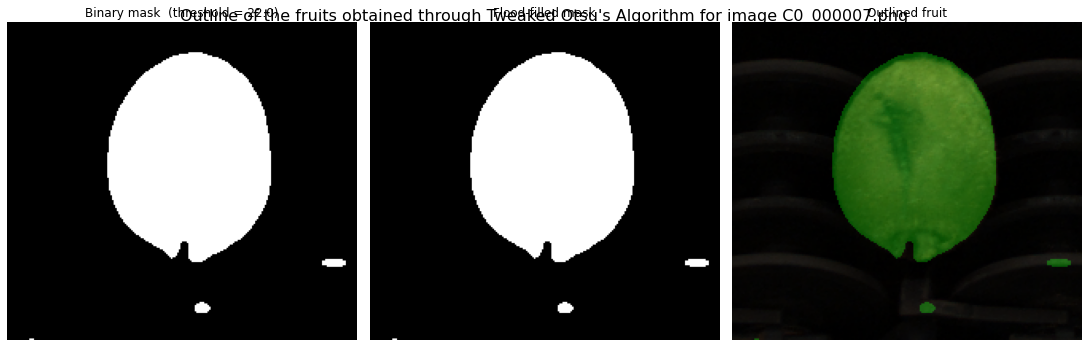

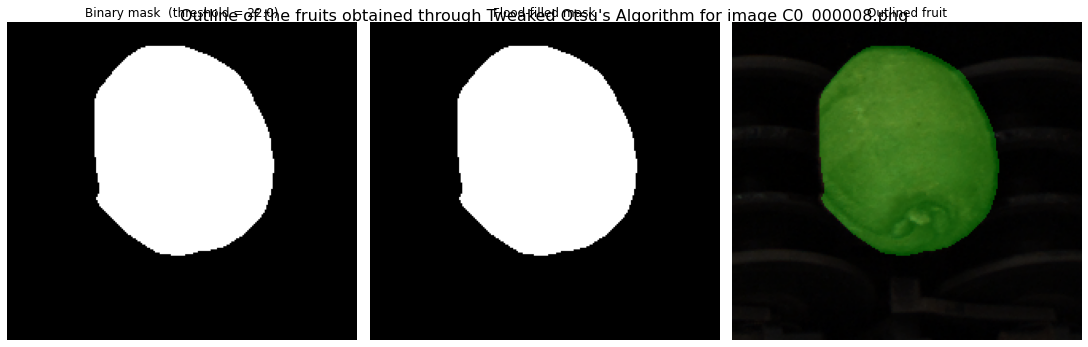

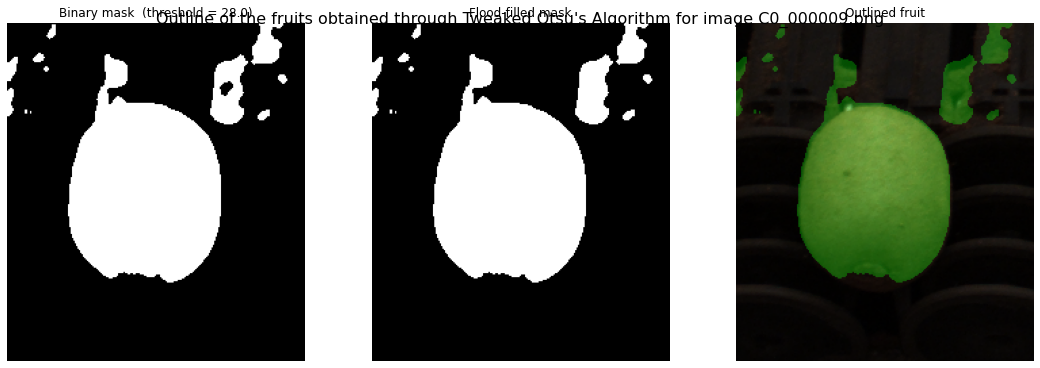

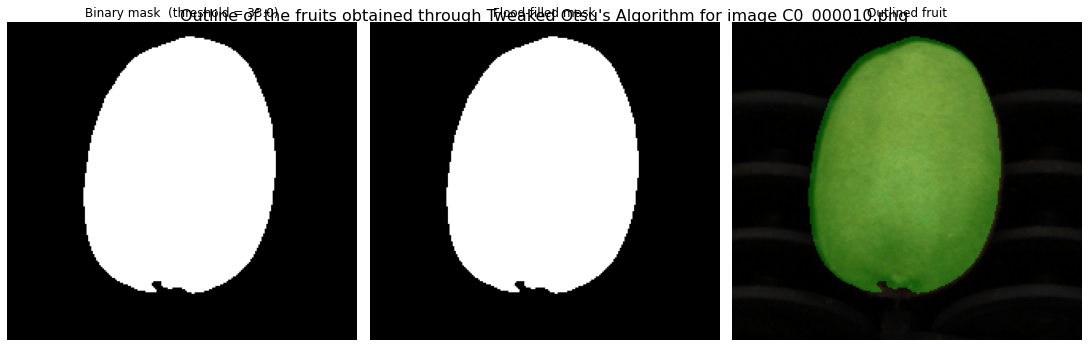

In [52]:
TWEAK_FACTOR = .45

plot_masking_process(filtered_images, colour_imgs, nir_names, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

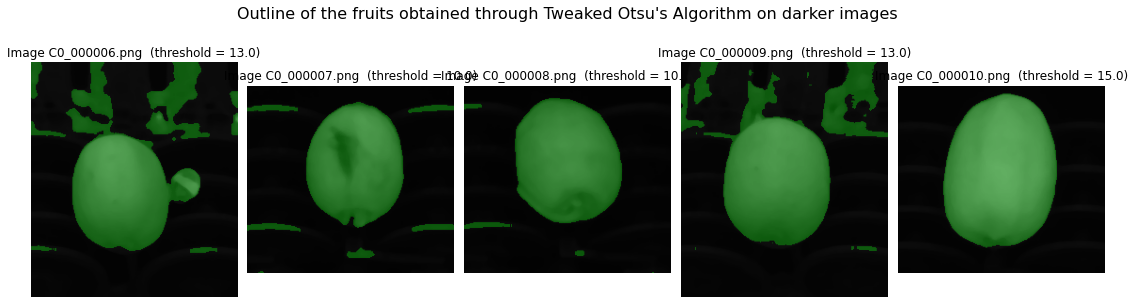

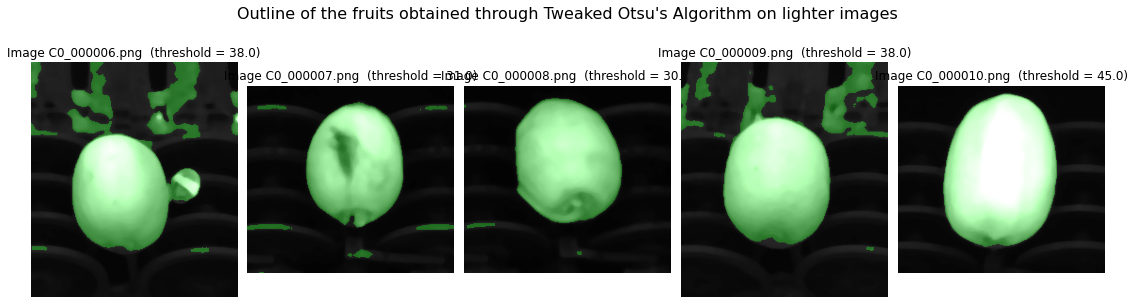

In [40]:
filtered_darker_images = [change_contrast_grayscale(img, .5) for img in filtered_images]
filtered_lighter_images = [change_contrast_grayscale(img) for img in filtered_images]

plot_image_grid(filtered_images, colour_names, 'Original images')
plot_image_grid(filtered_darker_images, colour_names, 'Darker images')
plot_image_grid(filtered_lighter_images, colour_names, 'Lighter images')
plot_thresholding_on_light_and_dark_images(filtered_darker_images, filtered_lighter_images, nir_names, 
                                           ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

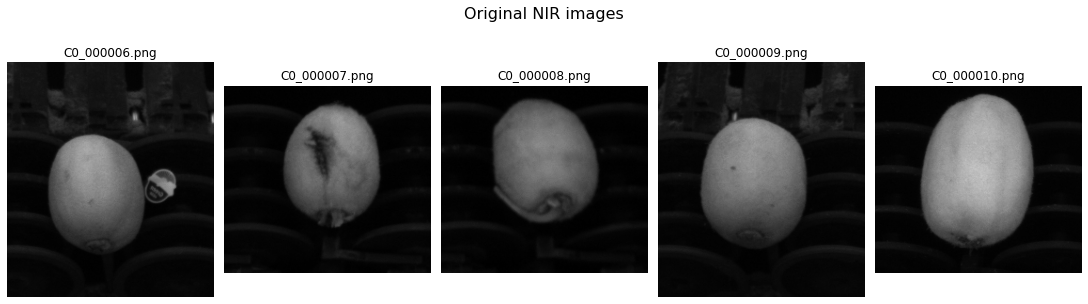

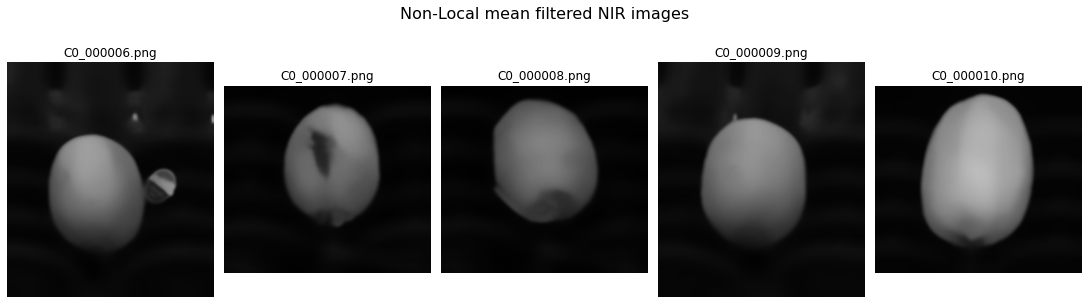

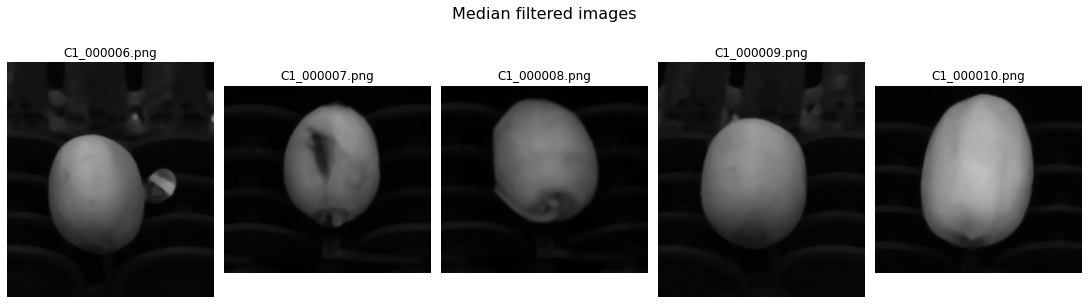

In [48]:
nl_filtered_imgs = [cv.fastNlMeansDenoising(img, h=25) for img in nir_imgs]
plot_image_grid(nir_imgs, nir_names, 'Original NIR images')
plot_image_grid(nl_filtered_imgs, nir_names, 'Non-Local mean filtered NIR images')
plot_image_grid(filtered_images, colour_names, 'Median filtered images')

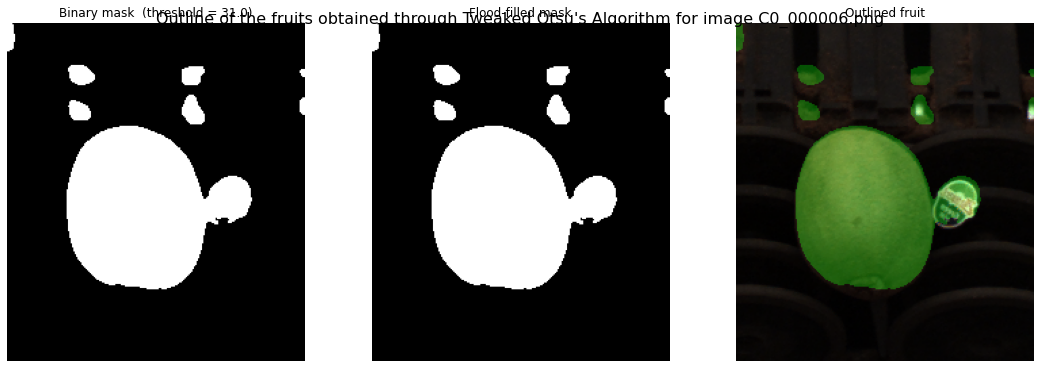

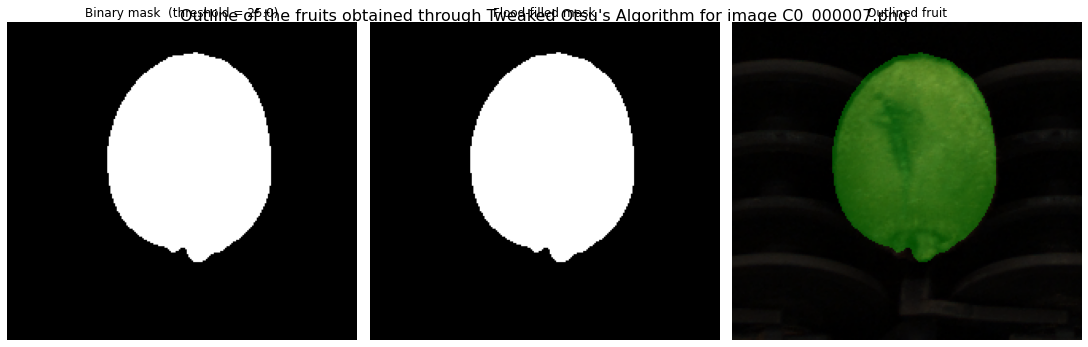

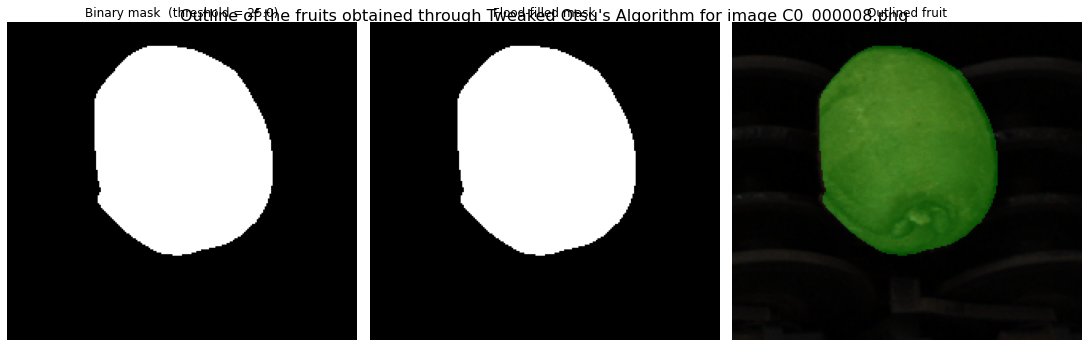

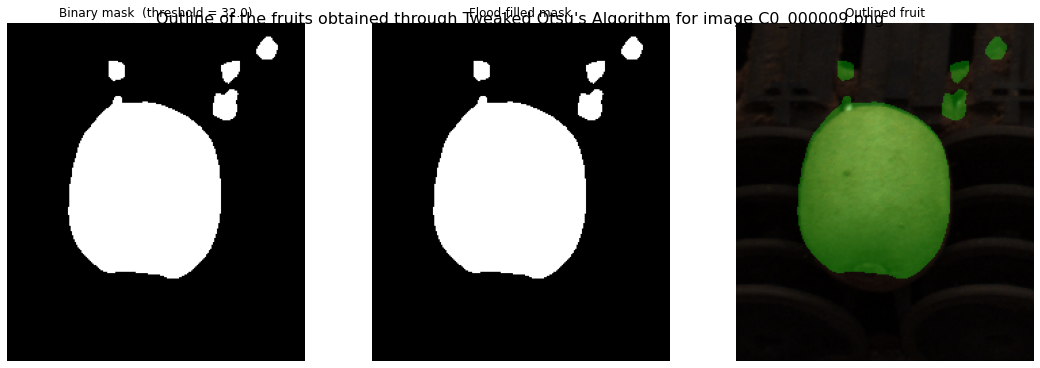

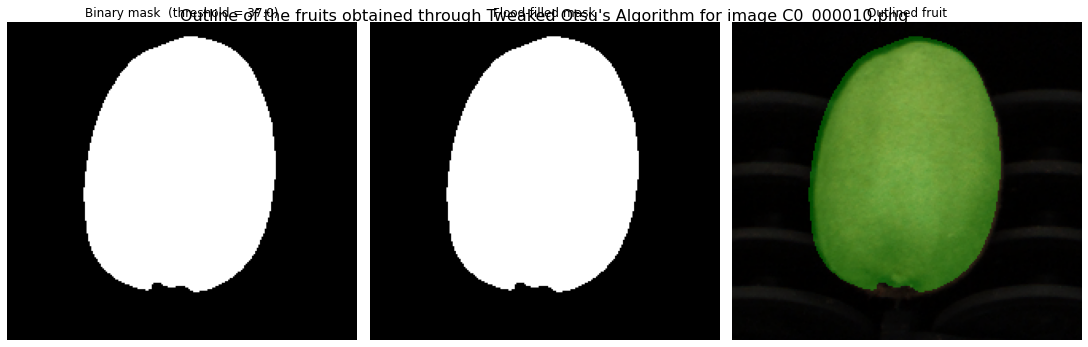

In [57]:
TWEAK_FACTOR = .5

plot_masking_process(nl_filtered_imgs, colour_imgs, nir_names, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

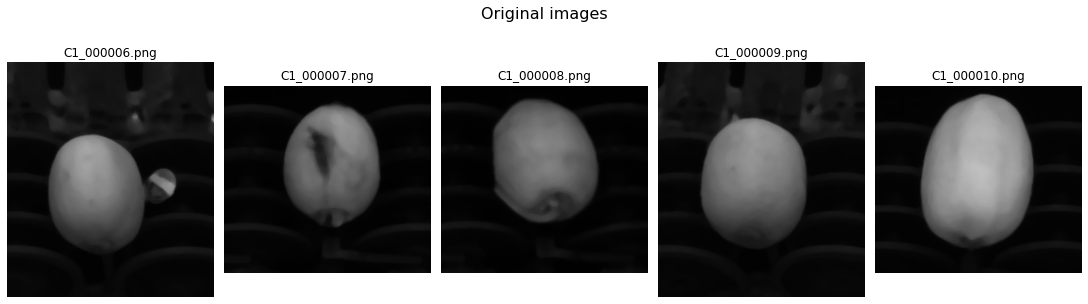

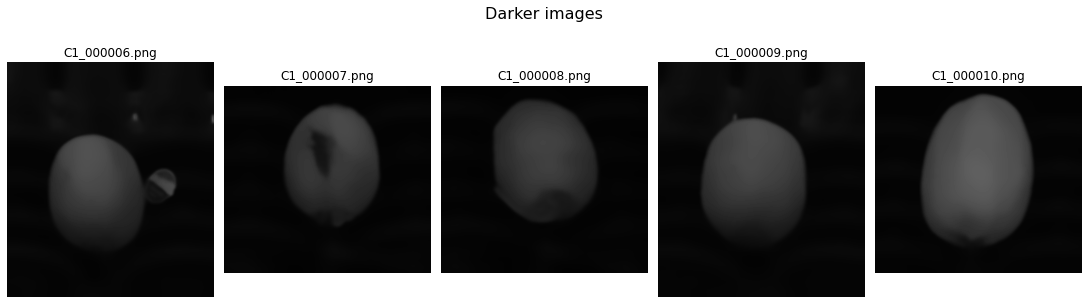

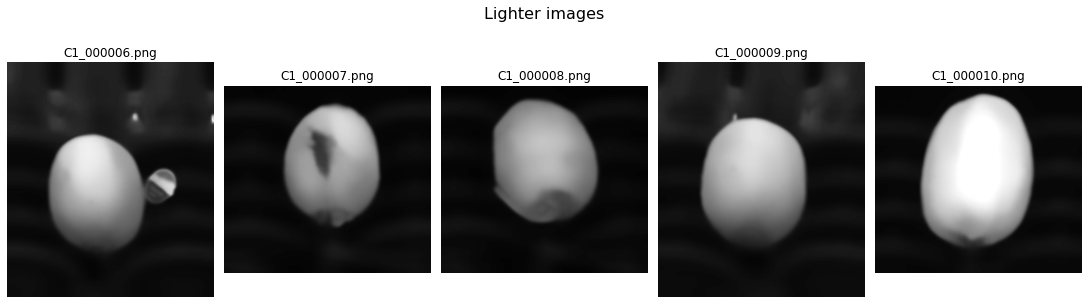

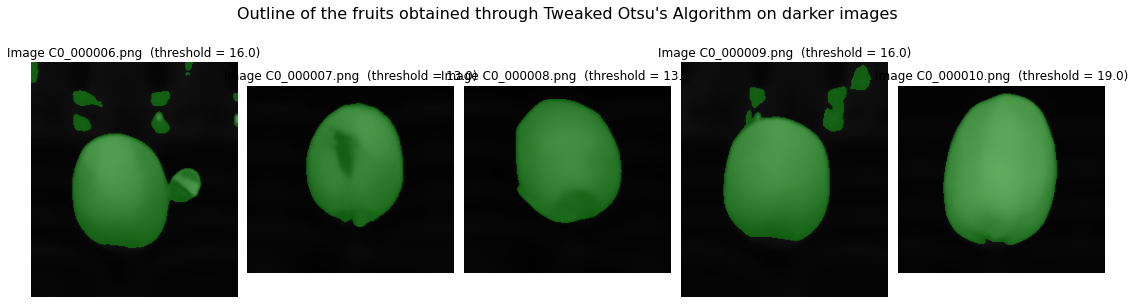

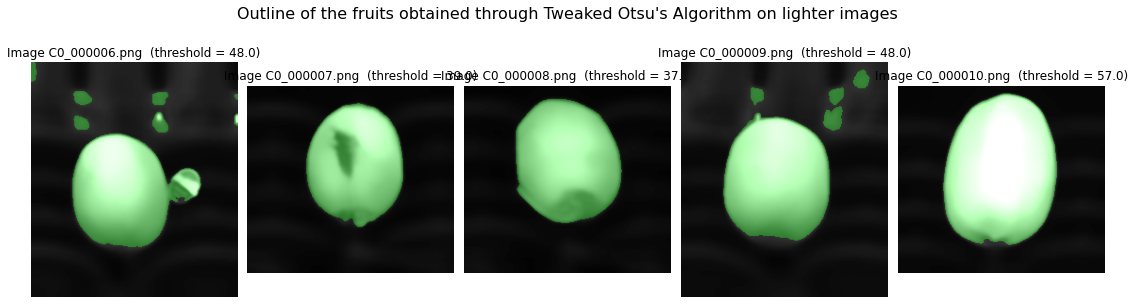

In [59]:
filtered_darker_images = [change_contrast_grayscale(img, .5) for img in nl_filtered_imgs]
filtered_lighter_images = [change_contrast_grayscale(img) for img in nl_filtered_imgs]

plot_image_grid(filtered_images, colour_names, 'Original images')
plot_image_grid(filtered_darker_images, colour_names, 'Darker images')
plot_image_grid(filtered_lighter_images, colour_names, 'Lighter images')
plot_thresholding_on_light_and_dark_images(filtered_darker_images, filtered_lighter_images, nir_names, 
                                           ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

In [62]:
s = time()
for img in nir_imgs * 100:
    cv.medianBlur(img,7)
median_time = time() - s

s = time()
for img in nir_imgs * 100:
    cv.fastNlMeansDenoising(img, h=25)
nl_denoising_time = time() - s

In [64]:
print(f'Time for preprocessing {100 * len(colour_imgs)} images with a median filter: {median_time:.6f}')
print(f'Mean time for preprocessing an image with a median filter: {(median_time / (100 * len(colour_imgs))):.6f}')
print()

print(f'Time for preprocessing {100 * len(colour_imgs)} images with a non-local mean filter: {nl_denoising_time:.6f}')
print(f'Mean time for preprocessing an image with a non-local mean filter: {(nl_denoising_time / (100 * len(colour_imgs))):.6f}')

Time for preprocessing 500 images with a median filter: 0.759258
Mean time for preprocessing an image with a median filter: 0.001519

Time for preprocessing 500 images with a non-local mean filter: 54.110467
Mean time for preprocessing an image with a non-local mean filter: 0.108221
